In [ ]:
%pip install numpy
%pip install tensorflow
%pip install gym
%pip install PIL.Image
%pip install pyvirtualdisplay
%pip install pandas
%pip install IPython
%pip install matplotlib
%pip install imageio
%pip install xauth


In [ ]:

%pip install gymnasium 
%pip install box2d box2d-kengz
%pip install pygame
%pip install gym[all]

In [105]:
import base64
import random
from itertools import zip_longest

import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import tensorflow as tf

import time
from collections import deque, namedtuple
import gymnasium as gym
import PIL.Image

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [106]:
# Set up a virtual display to render the Lunar Lander environment.
# Display(use_xauth=True, visible=0, size=(840, 480)).start(); # Python 3.11 not supported for display, try python.310

# Set the random seed for TensorFlow
tf.random.set_seed(0)

Constants:

In [107]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MINIBATCH_SIZE = 64  # Mini-batch size.
TAU = 1e-3  # Soft update parameter.
E_DECAY = 0.995  # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01  # Minimum ε value for the ε-greedy policy.


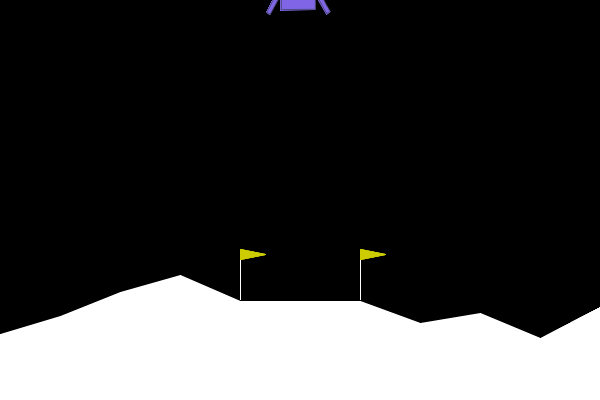

In [108]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
env.reset()
PIL.Image.fromarray(env.render())

Get State input vector size, and action vector size

In [109]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [110]:
current_state = env.reset()

Helper Functions:

In [111]:
def get_experiences(memory_buffer):
    """
    Returns a random sample of experience tuples drawn from the memory buffer.

    Retrieves a random sample of experience tuples from the given memory_buffer and
    returns them as TensorFlow Tensors. The size of the random sample is determined by
    the mini-batch size (MINIBATCH_SIZE). 
    
    Args:
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
        A tuple (states, actions, rewards, next_states, done_vals) where:

            - states are the starting states of the agent.
            - actions are the actions taken by the agent from the starting states.
            - rewards are the rewards received by the agent after taking the actions.
            - next_states are the new states of the agent after taking the actions.
            - done_vals are the boolean values indicating if the episode ended.

        All tuple elements are TensorFlow Tensors whose shape is determined by the
        mini-batch size and the given Gym environment. For the Lunar Lander environment
        the states and next_states will have a shape of [MINIBATCH_SIZE, 8] while the
        actions, rewards, and done_vals will have a shape of [MINIBATCH_SIZE]. All
        TensorFlow Tensors have elements with dtype=tf.float32.
    """

    # To improve efficiency we only sample a batch of the total examples in memory buffer
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)

In [112]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    """
    Determines if the conditions are met to perform a learning update.

    Checks if the current time step t is a multiple of num_steps_upd and if the
    memory_buffer has enough experience tuples to fill a mini-batch (for example, if the
    mini-batch size is 64, then the memory buffer should have more than 64 experience
    tuples in order to perform a learning update).
    
    Args:
        t (int):
            The current time step.
        num_steps_upd (int):
            The number of time steps used to determine how often to perform a learning
            update. A learning update is only performed every num_steps_upd time steps.
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
       A boolean that will be True if conditions are met and False otherwise. 
    """

    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [113]:
def get_new_eps(epsilon):
    """
    Updates the epsilon value for the ε-greedy policy.
    
    Gradually decreases the value of epsilon towards a minimum value (E_MIN) using the
    given ε-decay rate (E_DECAY).

    Args:
        epsilon (float):
            The current value of epsilon.

    Returns:
       A float with the updated value of epsilon.
    """

    return max(E_MIN, E_DECAY * epsilon)

In [114]:
def get_action(q_values, epsilon=0.0):
    """
    Returns an action using an ε-greedy policy.

    This function will return an action according to the following rules:
        - With probability epsilon, it will return an action chosen at random.
        - With probability (1 - epsilon), it will return the action that yields the
        maximum Q value in q_values.
    
    Args:
        q_values (tf.Tensor):
            The Q values returned by the Q-Network. For the Lunar Lander environment
            this TensorFlow Tensor should have a shape of [1, 4] and its elements should
            have dtype=tf.float32. 
        epsilon (float):
            The current value of epsilon.

    Returns:
       An action (numpy.int64). For the Lunar Lander environment, actions are
       represented by integers in the closed interval [0,3].
    """

    # Exploration vs Exploitation
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice([0,1, 2, 3])


In [115]:
def update_target_network(q_network, target_q_network):
    """
    Updates the weights of the target Q-Network using a soft update.
    
    The weights of the target_q_network are updated using the soft update rule:
    
                    w_target = (TAU * w) + (1 - TAU) * w_target
    
    where w_target are the weights of the target_q_network, TAU is the soft update
    parameter, and w are the weights of the q_network.
    
    Args:
        q_network (tf.keras.Sequential): 
            The Q-Network. 
        target_q_network (tf.keras.Sequential):
            The Target Q-Network.
    """

    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights) # Perform the soft update

In [116]:
def plot_history(point_history, **kwargs):
    """
    Plots the total number of points received by the agent after each episode together
    with the moving average (rolling mean). 

    Args:
        point_history (list):
            A list containing the total number of points the agent received after each
            episode.
        **kwargs: optional
            window_size (int):
                Size of the window used to calculate the moving average (rolling mean).
                This integer determines the fixed number of data points used for each
                window. The default window size is set to 10% of the total number of
                data points in point_history, i.e. if point_history has 200 data points
                the default window size will be 20.
            lower_limit (int):
                The lower limit of the x-axis in data coordinates. Default value is 0.
            upper_limit (int):
                The upper limit of the x-axis in data coordinates. Default value is
                len(point_history).
            plot_rolling_mean_only (bool):
                If True, only plots the moving average (rolling mean) without the point
                history. Default value is False.
            plot_data_only (bool):
                If True, only plots the point history without the moving average.
                Default value is False.
    """

    lower_limit = 0
    upper_limit = len(point_history)

    window_size = (upper_limit * 10) // 100

    plot_rolling_mean_only = False
    plot_data_only = False

    if kwargs:
        if "window_size" in kwargs:
            window_size = kwargs["window_size"]

        if "lower_limit" in kwargs:
            lower_limit = kwargs["lower_limit"]

        if "upper_limit" in kwargs:
            upper_limit = kwargs["upper_limit"]

        if "plot_rolling_mean_only" in kwargs:
            plot_rolling_mean_only = kwargs["plot_rolling_mean_only"]

        if "plot_data_only" in kwargs:
            plot_data_only = kwargs["plot_data_only"]

    points = point_history[lower_limit:upper_limit]

    # Generate x-axis for plotting.
    episode_num = [x for x in range(lower_limit, upper_limit)]

    # Use Pandas to calculate the rolling mean (moving average).
    rolling_mean = pd.DataFrame(points).rolling(window_size).mean()

    plt.figure(figsize=(10, 7), facecolor="white")

    if plot_data_only:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
    elif plot_rolling_mean_only:
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")
    else:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")

    text_color = "black"

    ax = plt.gca()
    ax.set_facecolor("black")
    plt.grid()
    plt.xlabel("Episode", color=text_color, fontsize=30)
    plt.ylabel("Total Points", color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter("{x:,}")
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis="x", colors=text_color)
    ax.tick_params(axis="y", colors=text_color)
    plt.show()

In [117]:
def embed_mp4(filename):
    """
    Embeds an MP4 video file in a Jupyter notebook.
    
    Args:
        filename (string):
            The path to the the MP4 video file that will be embedded (i.e.
            "./videos/lunar_lander.mp4").
    
    Returns:
        Returns a display object from the given video file. This will result in the
        video being displayed in the Jupyter Notebook.
    """

    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )

    return IPython.display.HTML(tag)


def create_video(filename, env, q_network, fps=30):
    """
    Creates a video of an agent interacting with a Gym environment.

    The agent will interact with the given env environment using the q_network to map
    states to Q values and using a greedy policy to choose its actions (i.e it will
    choose the actions that yield the maximum Q values).
    
    The video will be saved to a file with the given filename. The video format must be
    specified in the filename by providing a file extension (.mp4, .gif, etc..). If you 
    want to embed the video in a Jupyter notebook using the embed_mp4 function, then the
    video must be saved as an MP4 file. 
    
    Args:
        filename (string):
            The path to the file to which the video will be saved. The video format will
            be selected based on the filename. Therefore, the video format must be
            specified in the filename by providing a file extension (i.e.
            "./videos/lunar_lander.mp4"). To see a list of supported formats see the
            imageio documentation: https://imageio.readthedocs.io/en/v2.8.0/formats.html
        env (Gym Environment): 
            The Gym environment the agent will interact with.
        q_network (tf.keras.Sequential):
            A TensorFlow Keras Sequential model that maps states to Q values.
        fps (int):
            The number of frames per second. Specifies the frame rate of the output
            video. The default frame rate is 30 frames per second.  
    """

    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()[0]
        frame = env.render()
        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, truncated, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

In [118]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (1 - done_vals) * gamma * max_qsa
    
    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    loss = MSE(y_targets, q_values)
    
    return loss

In [119]:
@tf.function
def agent_learn(experiences, gamma, q_network, target_q_network, optimizer):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

Deep Q Learning

In [120]:
# Creating Q and Target Q networks
q_network = Sequential([
    Input(shape=state_size), # state_size = env.observation_space.shape
    tf.keras.layers.Dense(units=128, activation='relu'), # Simple dense neural net, will experiment for more optimal architectures
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=num_actions, activation='linear'),
    ])

target_q_network = Sequential([
    Input(shape=state_size),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=num_actions, activation='linear'),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)


Experience Replay

In [123]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

start = time.time()

num_episodes = 20000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)
# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state

    state = env.reset()[0]
    total_points = 0
    x = 0

    for t in range(max_num_timesteps):
        

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0) # state needs to be the right shape for the q_network

        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, truncated, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA, q_network, target_q_network, optimizer)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -106.68
Episode 200 | Total point average of the last 100 episodes: -47.260
Episode 300 | Total point average of the last 100 episodes: -10.07
Episode 400 | Total point average of the last 100 episodes: 134.80
Episode 500 | Total point average of the last 100 episodes: 132.44
Episode 600 | Total point average of the last 100 episodes: 60.031
Episode 700 | Total point average of the last 100 episodes: -190.83
Episode 800 | Total point average of the last 100 episodes: -306.05
Episode 900 | Total point average of the last 100 episodes: -340.40
Episode 1000 | Total point average of the last 100 episodes: -287.39
Episode 1100 | Total point average of the last 100 episodes: -283.21
Episode 1200 | Total point average of the last 100 episodes: -246.67
Episode 1300 | Total point average of the last 100 episodes: -211.24
Episode 1400 | Total point average of the last 100 episodes: -236.78
Episode 1500 | Total point average of the last 

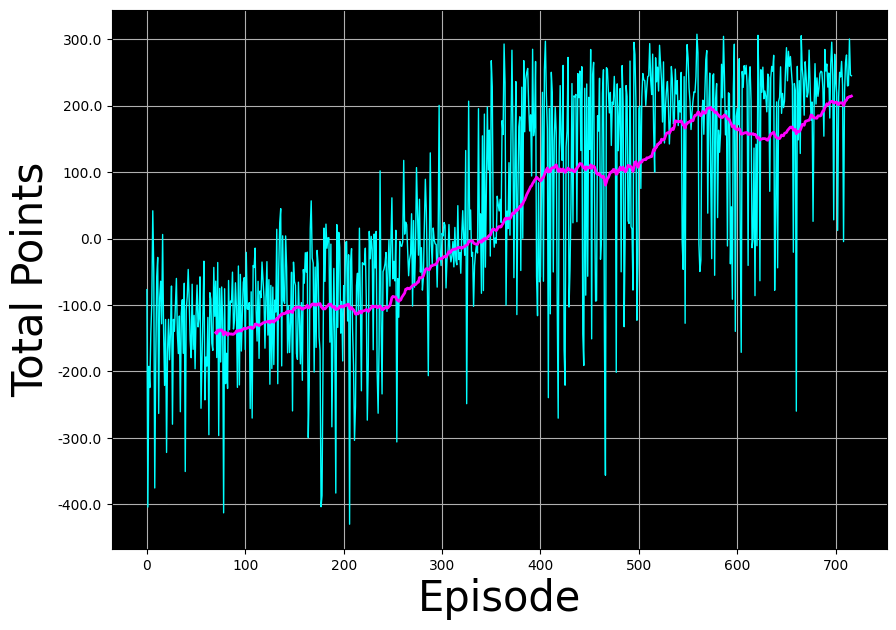

In [ ]:
plot_history(total_point_history)

In [ ]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [124]:
filename = ".lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)